In [43]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from typing import Tuple
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Task 1

### Hyperparameters

In [45]:
height = 28
width = 28
input_size = height * width
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

### Load the MNIST train and test set

In [46]:
train_dataset = datasets.MNIST(root='./data', train=True,
                               download=True, transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='./data', train=False,
                              download=True, transform=transforms.ToTensor())

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

`torch.utils.data.DataLoader` is a PyTorch utility class that helps in loading the data in batches for training a neural network. It takes the dataset (`train_dataset` in this case) and several optional arguments to configure the data loading process.

Here's an explanation of the arguments used in `torch.utils.data.DataLoader`:

* `train_dataset`: This is the training dataset object that we want to load in batches. It contains the input images and labels.

* `batch_size`: It specifies the number of samples in each batch. During training, the model will process `batch_size` number of images together and update the model's parameters based on the computed gradients. A smaller batch size can lead to more frequent parameter updates but may require more memory, while a larger batch size can improve computational efficiency but may result in slower convergence.

* `shuffle=True`: This argument controls whether to shuffle the training data before each epoch. Setting it to `True` randomizes the order of the samples in each epoch, which helps in reducing the impact of any specific order or pattern in the data. Shuffling the data is important to prevent the model from learning the order of the samples instead of the underlying patterns.


### Implement a basic two-layer fully connected neural network

In [47]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

        self.relu_output = None

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        self.relu_output = out
        out = self.fc2(out)
        return out

 We define a class `Net` that inherits from `nn.Module`, which is the base class for all neural network modules in PyTorch.

 We define the layers of the network: a fully connected layer (nn.Linear) with ReLU activation function (nn.ReLU), followed by another fully connected layer.

 The `forward` function pass the input through all the layers.

 
 



### Training step

In [48]:

def train_model_step(model: Net, dataloader: DataLoader, optimizer: Optimizer, criterion: nn.CrossEntropyLoss) -> None:
    model.train()
    for data, label in dataloader:
        data: torch.Tensor
        label: torch.Tensor
        
        data = data.reshape(-1, input_size).to(device)
        label = label.to(device)

        outputs = model(data)
        loss = criterion(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

1. Sets the model in training mode.
2. The loop `for data, label in dataloader` : iterates over the **batches** in the training data. It provides both the batch of images and their corresponding labels.
3. `data = data.reshape(-1, input_size)` reshapes the images from a 4-dimensional tensor (batch_size, channels, height, width) to a 2-dimensional tensor (batch_size, input_size). The `-1` in the reshape operation indicates that the batch size dimension is inferred automatically based on the other dimensions.
4. The forward pass is performed by calling ` outputs = model(data)`. This feeds the reshaped images **through the neural network model, producing predicted outputs for each input image**
5. The loss is calculated using the specified loss function by calling `loss = criterion(outputs, label)`. It compares the predicted outputs with the true labels and quantifies the model's performance.
6. `optimizer.zero_grad()` clears the gradients of all optimized parameters. This step is necessary before computing the gradients in the backward pass.
7. `loss.backward()` computes the gradients of the loss with respect to the model's parameters using backpropagation. It calculates the gradient of the loss function with respect to each parameter in the model.
8. `optimizer.step()` updates the model's parameters based on the computed gradients and the chosen optimization algorithm. It performs a parameter update using the gradients and the specified learning rate.

### Implement evaluation procedure

In [49]:
def evaluate_model(model: Net, dataloader, criterion) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    with torch.no_grad():
        for data, label in dataloader:
            data = data.reshape(-1, input_size).to(device)
            label = label.to(device)
        
            output = model(data)
            loss = criterion(output, label)
            
            _, predicted = torch.max(output.data, 1)
            running_loss += loss.item()
            running_accuracy += (predicted == label).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100.0 * running_accuracy / len(dataloader.dataset)

    return epoch_loss, epoch_accuracy

1. Sets the model to evaluation mode.
2. Initialize variables `running_loss`, and `running_accuracy` to keep track of the cumulative loss, and accuracy in the evaluation process.
3. Use a `with torch.no_grad()` block to disable gradient calculation during evaluation. This saves memory and computation since gradients are not needed for evaluation.
4. Iterate over the data in the dataloader using a for loop. Each iteration provides a batch of images and their corresponding labels.
5. Reshape the images using `data.reshape(-1, input_size)` to flatten each image into a 1D tensor. This ensures that the input has the expected shape for the model.
6. Pass the flattened images through the model to obtain the predicted outputs using `outputs = model(data)`.
7. Calculate the loss between the predicted outputs and the ground truth labels using the specified criterion (`criterion(outputs, labels)`).
8. Use `torch.max(outputs.data, 1)` to find the index of the maximum value in each output tensor, which represents the predicted class labels.
9. Update the running loss by multiplying the loss with the number of samples in the current batch (`loss.item() * data.size(0)`)
10. Update the running accuracy by summing the number of correctly predicted samples (`(predicted == labels).sum().item()`).
11. Calculate the average loss by dividing the running loss by the total number of samples (`running_loss / total_samples`).
12. Calculate the accuracy as a percentage by multiplying the running accuracy by 100 and dividing by the total number of samples (`100.0 * running_accuracy / total_samples`).
13. Return the average loss and accuracy as the output of the function.

In [50]:
def run_model(model, criterion, train_loss_history, train_acc_history, test_loss_history , test_acc_history, train_dataloader, test_dataloader):
    train_loss, train_acc = evaluate_model(model, train_dataloader, criterion)
    test_loss, test_acc = evaluate_model(model, test_dataloader, criterion)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

In [51]:
def task_1(model ,criterion, optimizer, train_dataloader, test_dataloader, val_dataloader):

    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    run_model(model, criterion, train_loss_history, train_acc_history, test_loss_history , test_acc_history, train_dataloader, test_dataloader)

    for epoch in range(num_epochs):
    
        train_model_step(model, train_dataloader, optimizer, criterion)
        run_model(model, criterion, train_loss_history, train_acc_history, test_loss_history , test_acc_history, train_dataloader, test_dataloader)
    
    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

In [52]:
model = Net(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss_history, test_loss_history, train_acc_history, test_acc_history = task_1(model ,criterion, optimizer, train_dataloader, test_dataloader, [])

for i in range(num_epochs + 1):
    print(f'Epoch [{i}/{num_epochs}], Train Loss: {train_loss_history[i]:.4f}, Train Acc: {train_acc_history[i]:.2f}%, Test Loss: {test_loss_history[i]:.4f}, Test Acc: {test_acc_history[i]:.2f}%')

Epoch [0/5], Train Loss: 2.2981, Train Acc: 11.43%, Test Loss: 2.2981, Test Acc: 11.63%
Epoch [1/5], Train Loss: 0.1403, Train Acc: 95.99%, Test Loss: 0.1458, Test Acc: 95.72%
Epoch [2/5], Train Loss: 0.0926, Train Acc: 97.24%, Test Loss: 0.1040, Test Acc: 96.89%
Epoch [3/5], Train Loss: 0.0593, Train Acc: 98.27%, Test Loss: 0.0847, Test Acc: 97.42%
Epoch [4/5], Train Loss: 0.0371, Train Acc: 98.95%, Test Loss: 0.0727, Test Acc: 97.76%
Epoch [5/5], Train Loss: 0.0274, Train Acc: 99.26%, Test Loss: 0.0667, Test Acc: 98.01%


## Add a plot of the train and test error graphs during training

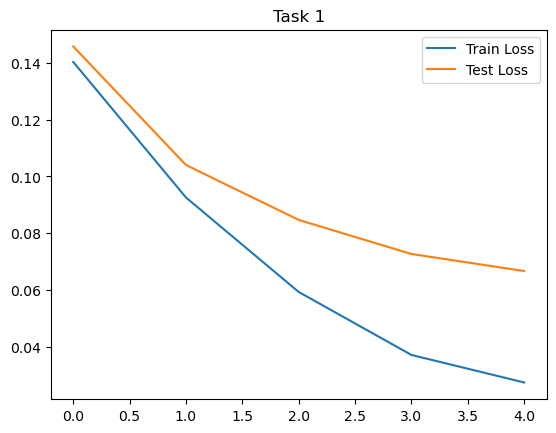

In [53]:

def task_1_plot(train_loss_history, test_loss_history, title):
    plt.plot(train_loss_history[1:], label='Train Loss')
    plt.plot(test_loss_history[1:], label='Test Loss')
    plt.legend()
    plt.title(title)
    plt.show()

task_1_plot(train_loss_history ,test_loss_history, "Task 1")

## Report the test error you obtain when training has finished

In [54]:
last_lose_train = train_loss_history[-1]
last_lose_test = test_loss_history[-1]
print(last_lose_train)
print(last_lose_test)

0.027380925855444122
0.06665730951877777


## Attach to your report a plot of some of the misclassified images

In [55]:
def get_misclasified_images(num_of_images):
    counter = 0
    misclassified_images = []
    with torch.no_grad():
        for data, label in test_dataloader:
            data = data.reshape(-1, input_size).to(device)
            label = label.to(device)
        
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            mask = (predicted != label)
            
            for img, pred, actual in zip(data[mask], predicted[mask], label[mask]):
                misclassified_images.append((img, pred, actual))
                counter += 1

            if counter >= num_of_images:
                break
    return misclassified_images
        

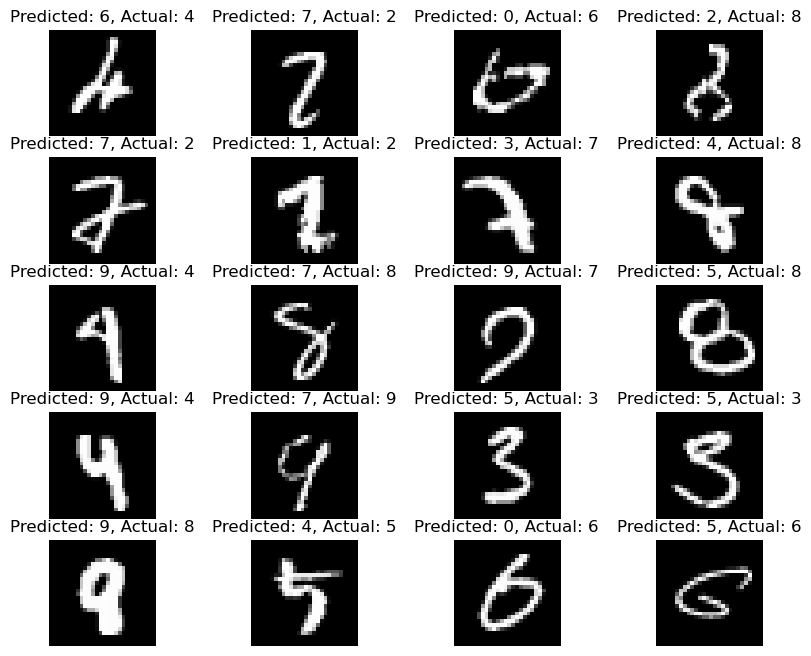

In [56]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 8))

misclassified_images = get_misclasified_images(20)
for ax, (img, pred, actual) in zip(axes.flat, misclassified_images):
    img = img.cpu().numpy().reshape(height, width)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Predicted: {pred}, Actual: {actual}')
    ax.axis('off')
plt.show()

# Task 2

###  Attach a plot of the test errors during training from the separate runs

In [57]:
def task_2_plot(all_train_history, all_test_history):
    colors = ['b', 'g', 'r', 'm', 'y']
    for i in range(5) :
        train_loss = all_train_history[i]
        test_loss = all_test_history[i]
        plt.plot(train_loss[1:], color = colors[i], label = f"Train Loss - Seed number {i}")
        plt.plot(test_loss[1:], color = colors[i], label = f"Test Loss - Seed number {i}", linestyle='--')
    plt.legend()
    plt.title("Task 2")
    plt.show()
    
    

In [58]:
def task_2(f, hidden_size, learning_rate, train_dataloader, test_dataloader, val_dataloader):
    all_train_history = []
    all_test_history = []
    all_val_history = []
    final_err = []

    for i in range(5):
        torch.manual_seed(i)
        model = Net(input_size, hidden_size, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_loss_history, test_loss_history, val_loss_history, _ = f(model ,criterion, optimizer, train_dataloader, test_dataloader, val_dataloader)
        all_train_history.append(train_loss_history)
        all_test_history.append(test_loss_history)
        all_val_history.append(val_loss_history)
        final_err.append(test_loss_history[num_epochs])
    
    return all_train_history, all_test_history, all_val_history, final_err



In [59]:
all_train_history, all_test_history, _, final_err = task_2(task_1, hidden_size, learning_rate, train_dataloader, test_dataloader, [])

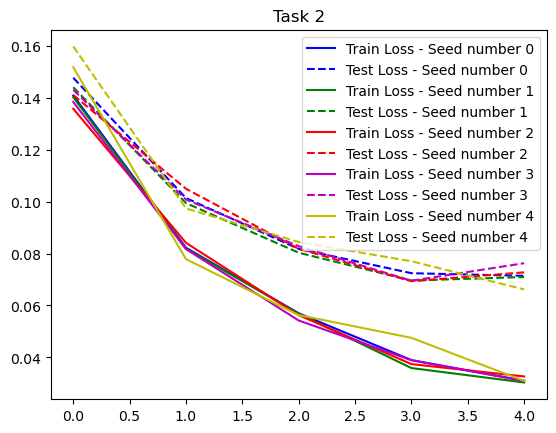

In [60]:

task_2_plot(all_train_history, all_test_history)

### Report the mean and standard deviation of the final test errors

In [61]:
mean_value = np.mean(final_err)

std_deviation = np.std(final_err)

variance = np.var(final_err)

print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_deviation}")
print(f"variance : {variance}")

Mean: 0.07151540613797261
Standard Deviation: 0.0032642056800724823
variance : 1.0655038721817457e-05


# Task 3

### Split the MNIST dataset to three sets

In [62]:
val_set_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataloader.dataset) - val_set_size, val_set_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

###  Repeat the training required in Task 2 of five different models

In [63]:
def run_model_task_3(model, criterion, train_loss_history, train_acc_history, test_loss_history , test_acc_history, val_loss_history, val_acc_history, train_dataloader, test_dataloader, val_dataloader):
    train_loss, train_acc = evaluate_model(model, train_dataloader, criterion)
    test_loss, test_acc = evaluate_model(model, test_dataloader, criterion)
    val_loss, val_acc = evaluate_model(model, val_dataloader, criterion)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

In [64]:
def task_3(model ,criterion, optimizer, train_dataloader, test_dataloader, val_dataloader):

    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []
    val_loss_history = []
    val_acc_history = []

    run_model_task_3(model, criterion, train_loss_history, train_acc_history, test_loss_history , test_acc_history, val_loss_history, val_acc_history, train_dataloader, test_dataloader, val_dataloader)

    for epoch in range(num_epochs):
    
        train_model_step(model, train_dataloader, optimizer, criterion)
        run_model_task_3(model, criterion, train_loss_history, train_acc_history, test_loss_history , test_acc_history, val_loss_history, val_acc_history, train_dataloader, test_dataloader, val_dataloader)
    
    return train_loss_history, test_loss_history, val_loss_history, []

In [65]:
all_train_history, all_test_history, all_val_history, _ = task_2(task_3, hidden_size, learning_rate, train_dataloader, test_dataloader, val_dataloader)


In [66]:
def task_3_plot(all_train_history, all_test_history, all_val_history):
    colors = ['b', 'g', 'r', 'm', 'y']
    ax = plt.subplot(111)
    for i in range(5) :
        train_loss = all_train_history[i]
        test_loss = all_test_history[i]
        val_loss = all_val_history[i]

        plt.plot(train_loss[1:], color = colors[i], label = f"Train Loss - Seed number {i}")
        plt.plot(test_loss[1:], color = colors[i], label = f"Test Loss - Seed number {i}", linestyle='--')
        plt.plot(val_loss[1:], color = colors[i], label = f"val Loss - Seed number {i}", linestyle=':')
        
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("Task 3")
    plt.show()

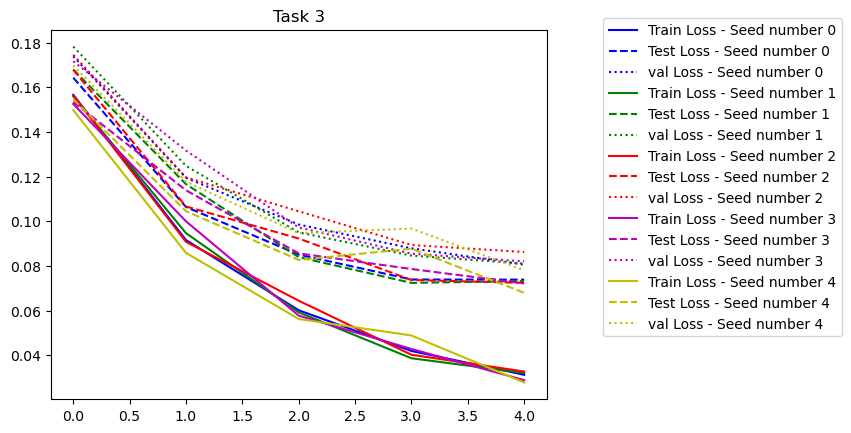

In [67]:
task_3_plot(all_train_history, all_test_history, all_val_history)

In [68]:
print(all_test_history)

[[2.2868259859085085, 0.16427725997753442, 0.10639124426990748, 0.08508383204811253, 0.07393428603245411, 0.07386987520352704], [2.3037158060073852, 0.16792200633790344, 0.11660941591253504, 0.08393873787834309, 0.07241771863715257, 0.0732405790485791], [2.31082421541214, 0.16783937075175345, 0.1066374120558612, 0.09227914403483738, 0.07371995622699615, 0.07241527115227654], [2.2991752076148986, 0.1534146194625646, 0.1138755951821804, 0.0856306063028751, 0.07862516475433949, 0.07216720649885247], [2.302232186794281, 0.15465233908966183, 0.10449919194797985, 0.08269200567388907, 0.08773357984377071, 0.06797768970631296]]


### Report the test error that corresponds to the minimum validation error

In [69]:
test_error_corresponds = []

for i in range(len(all_val_history)):
    min = np.min(all_val_history[i])
    min_index = all_val_history[i].index(min)
    test_error_corresponds.append([min, all_test_history[i][min_index]])


for i in range(5):
    print(f"Seed number {i} : Minimum val error = {test_error_corresponds[i][0]} , correspond test error = {test_error_corresponds[i][1]} ")
    

Seed number 0 : Minimum val error = 0.08058689292520285 , correspond test error = 0.07386987520352704 
Seed number 1 : Minimum val error = 0.081047693756409 , correspond test error = 0.0732405790485791 
Seed number 2 : Minimum val error = 0.08624023072421551 , correspond test error = 0.07241527115227654 
Seed number 3 : Minimum val error = 0.08204581999219954 , correspond test error = 0.07216720649885247 
Seed number 4 : Minimum val error = 0.07805490160360933 , correspond test error = 0.06797768970631296 


### Choose the seed for task 4

In [70]:
values = [sublist[1] for sublist in test_error_corresponds]
min = np.min(values)
seed = values.index(min)



# Task 4

###  Choose the possible values for each parameter and train models for each combination of parameters

In [71]:
import itertools
num_of_values = 3
hidden_size_start = 256
batch_size_start = 64
learning_rates = [0.001 , 0.01]
hidden_sizes = [hidden_size_start]
batch_sizes = [batch_size_start]

for i in range(num_of_values-1):
    hidden_sizes.append(2*hidden_sizes[i])
    batch_sizes.append(2*batch_sizes[i])

combinations = list(itertools.product(hidden_sizes, batch_sizes, learning_rates))
print(combinations)

[(256, 64, 0.001), (256, 64, 0.01), (256, 128, 0.001), (256, 128, 0.01), (256, 256, 0.001), (256, 256, 0.01), (512, 64, 0.001), (512, 64, 0.01), (512, 128, 0.001), (512, 128, 0.01), (512, 256, 0.001), (512, 256, 0.01), (1024, 64, 0.001), (1024, 64, 0.01), (1024, 128, 0.001), (1024, 128, 0.01), (1024, 256, 0.001), (1024, 256, 0.01)]


In [72]:
def train_according_to_chosen_seed_and_parameters(seed, f, hidden_size, learning_rate, train_dataloader, test_dataloader, val_dataloader):        
        torch.manual_seed(seed)
        model = Net(input_size, hidden_size, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_loss_history, test_loss_history, val_loss_history, _ = f(model ,criterion, optimizer, train_dataloader, test_dataloader, val_dataloader)

        return train_loss_history, test_loss_history, val_loss_history
        

In [73]:
def task_4_plot(train_loss, test_loss, val_loss, i):
    ax = plt.subplot(111)
    
    plt.plot(train_loss[1:], label = "Train Loss")
    plt.plot(test_loss[1:], label = "Test Loss", linestyle='--')
    plt.plot(val_loss[1:], label = "val Loss", linestyle=':')
        
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(f"Task 4 combination {i}")
    plt.show()

### Finding index of minimum validation error

In [74]:
def minimum_validation_error(all_val_history):
    min = np.min(all_val_history)
    min_index = all_val_history.index(min)
    return min_index


### Finding  the test error that corresponds to the minimum validation error

In [75]:
def corresponds_error(min_index, all_test_history):
    return all_test_history[min_index]

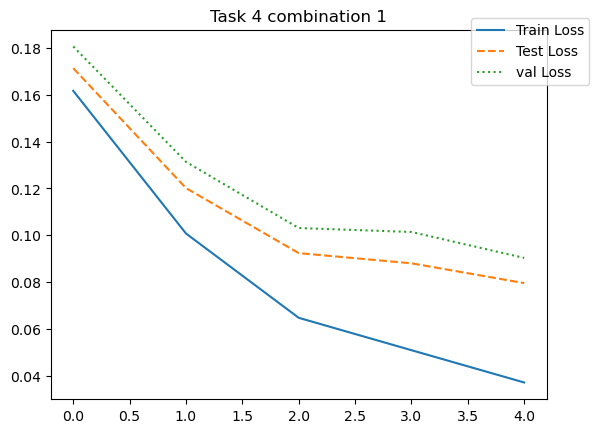

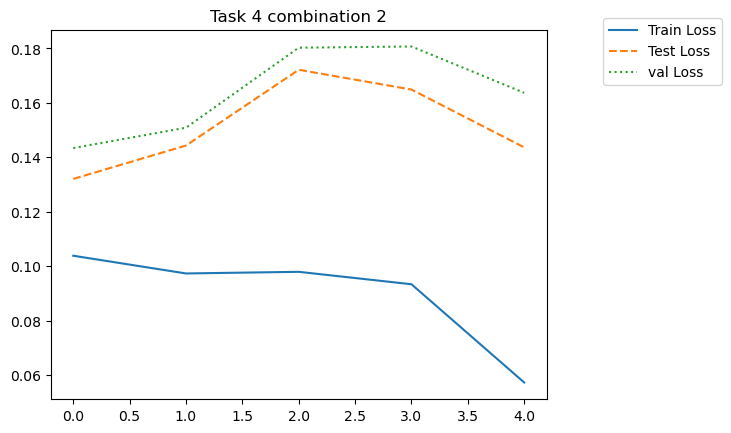

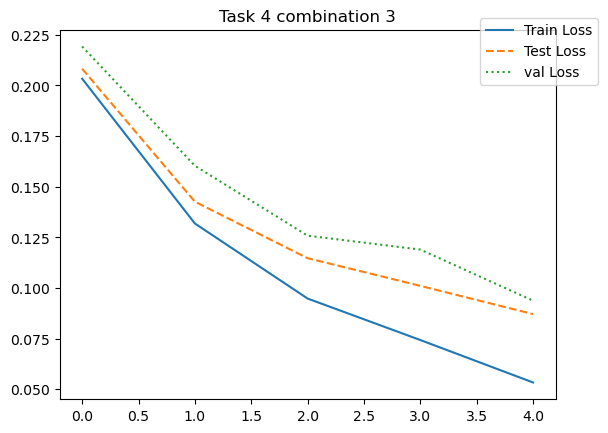

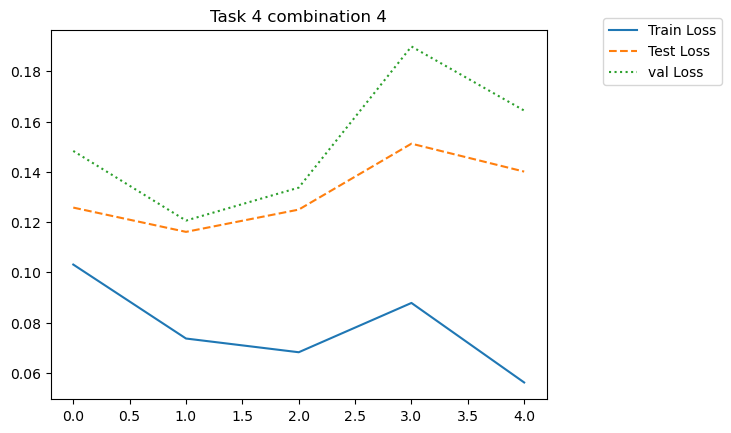

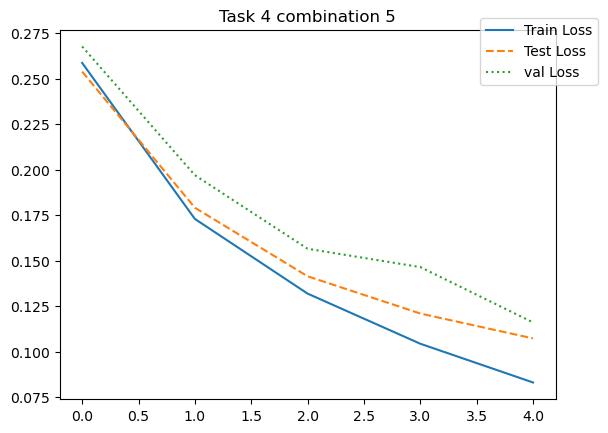

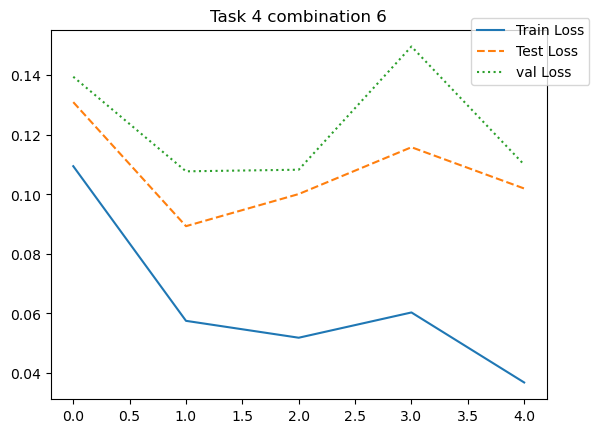

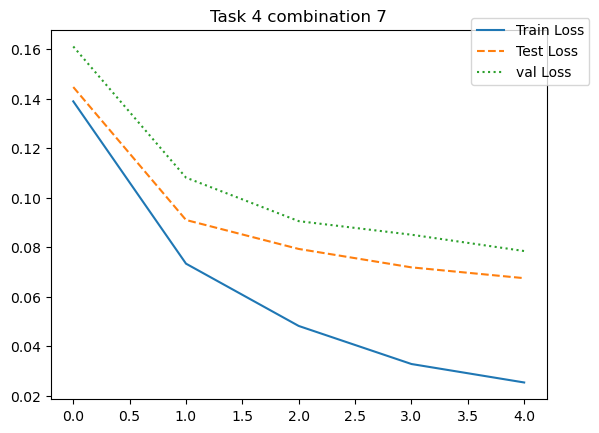

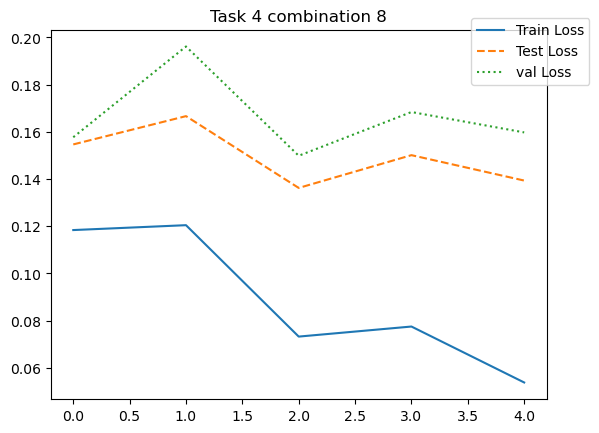

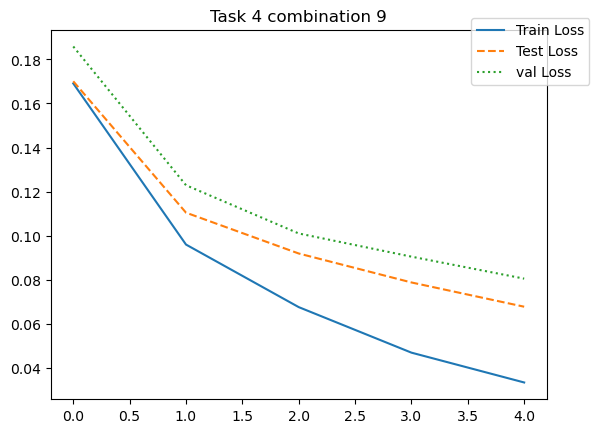

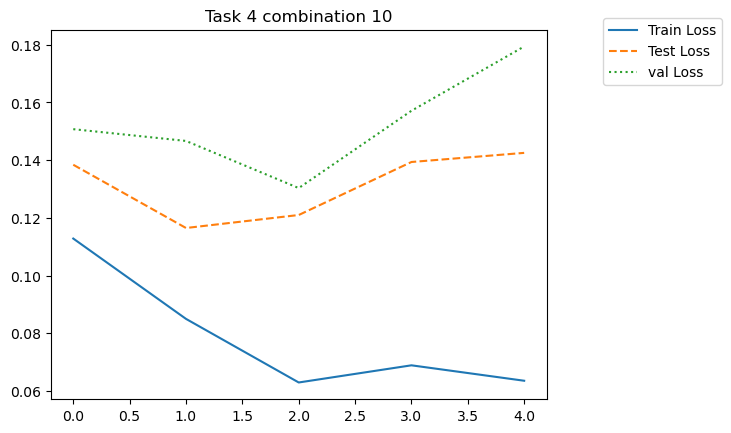

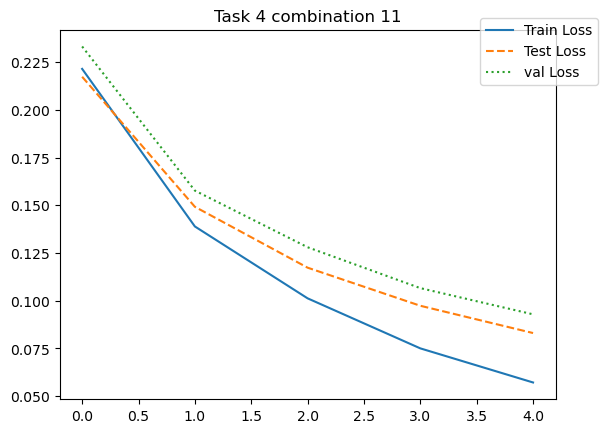

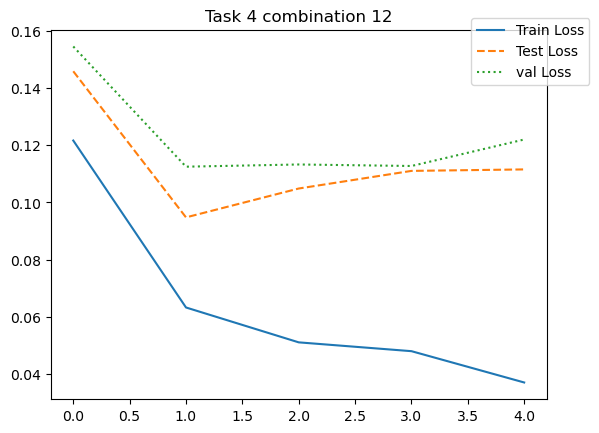

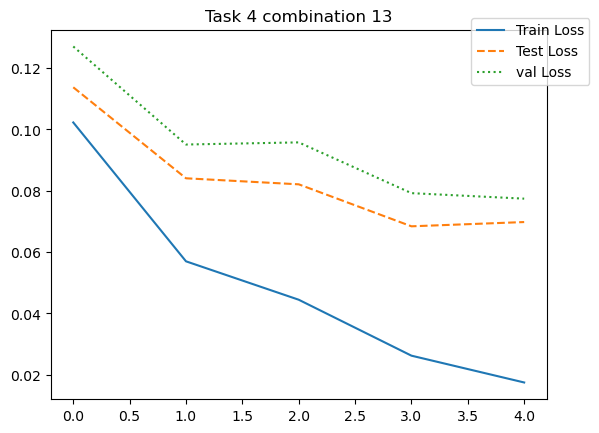

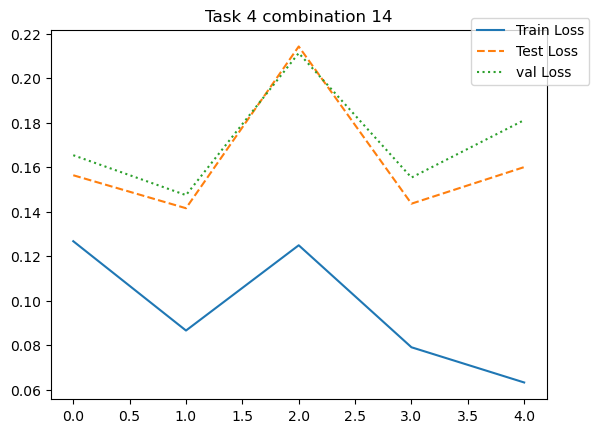

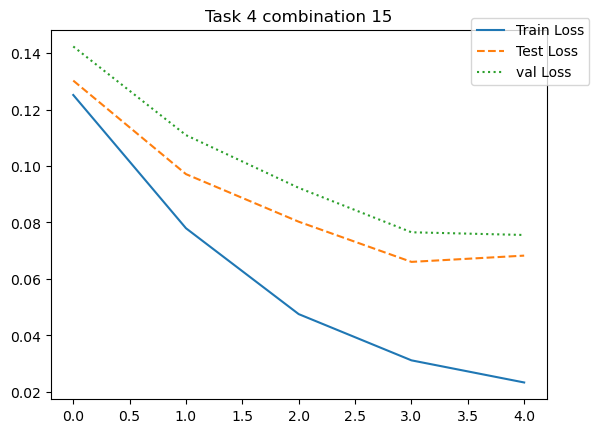

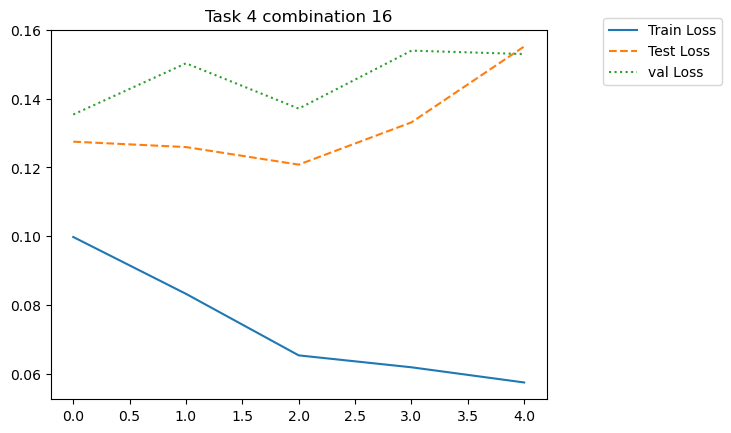

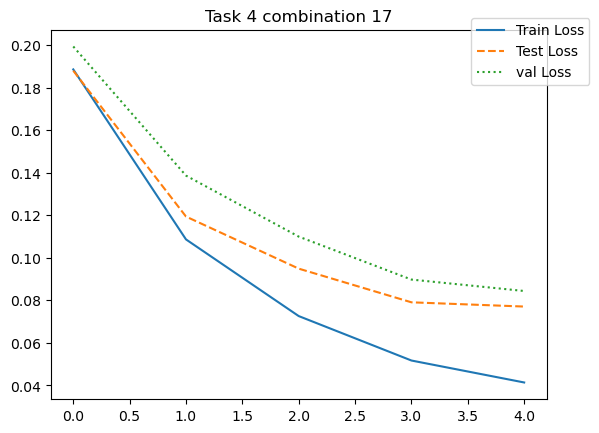

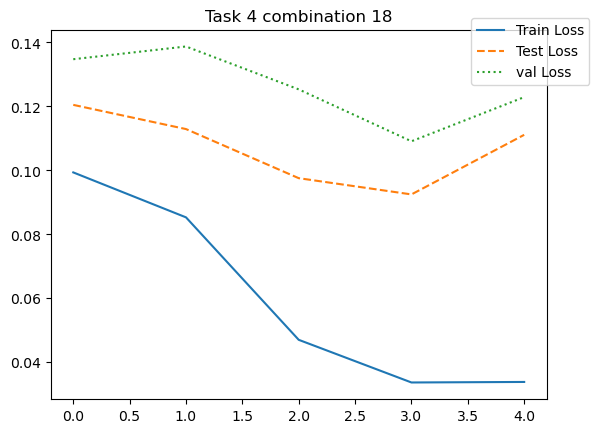

In [76]:
best_pairs = []
for i, (hidden_size, batch_size, learning_rate) in enumerate(combinations) :
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_train_history, all_test_history, all_val_history = train_according_to_chosen_seed_and_parameters(seed, task_3, hidden_size, learning_rate, train_dataloader, test_dataloader, val_dataloader)
    
    min_index = minimum_validation_error(all_val_history)
    corr_test_error = corresponds_error(min_index, all_test_history)
    best_pairs.append([all_val_history[min_index], corr_test_error])

    task_4_plot(all_train_history, all_test_history, all_val_history, i+1)





In [77]:
def print_pairs(best_pairs):
    for i in range(len(best_pairs)):
        print(f"Combination number {i+1}. Val minimum error = {best_pairs[i][0]} , corresponds test error = {best_pairs[i][1]}")

In [78]:
print_pairs(best_pairs)

Combination number 1. Val minimum error = 0.09028891886430229 , corresponds test error = 0.07952076562896822
Combination number 2. Val minimum error = 0.14341057388550915 , corresponds test error = 0.13207913312149325
Combination number 3. Val minimum error = 0.09377638028958175 , corresponds test error = 0.08716213991172918
Combination number 4. Val minimum error = 0.1205724262031196 , corresponds test error = 0.11608156775377833
Combination number 5. Val minimum error = 0.11601050577592105 , corresponds test error = 0.10723503585904837
Combination number 6. Val minimum error = 0.10774062359705568 , corresponds test error = 0.08932043956301641
Combination number 7. Val minimum error = 0.07841968903270592 , corresponds test error = 0.06745903992419802
Combination number 8. Val minimum error = 0.1498450480437108 , corresponds test error = 0.136206007820573
Combination number 9. Val minimum error = 0.08050326305099681 , corresponds test error = 0.06776760498215031
Combination number 10. 

### Best performance

##### According to min val error & min test error

In [79]:
best_min_val = [sublist[0] for sublist in best_pairs]
corr_test = [sublist[1] for sublist in best_pairs]

best_min_val_index =  best_min_val.index(np.min(best_min_val))
min_corr_test_index =  corr_test.index(np.min(corr_test))

print(f"According to min val error : Val minimum error = {best_min_val[best_min_val_index]} , corresponds test error = {corr_test[best_min_val_index]}")
print(f"According to min test error : Val minimum error = {best_min_val[min_corr_test_index]} , corresponds test error = {corr_test[min_corr_test_index]}")

According to min val error : Val minimum error = 0.07557769612515275 , corresponds test error = 0.06826453398039294
According to min test error : Val minimum error = 0.07841968903270592 , corresponds test error = 0.06745903992419802


### Highlight the combination that yields the best performance and set them

In [80]:
best_combination = combinations[best_min_val_index]
hidden_size = best_combination[0]
batch_size = best_combination[1]
learning_rate = best_combination[2]

In [81]:
print(best_combination)

(1024, 128, 0.001)


# Task 5

In [82]:
from sklearn.manifold import TSNE

In [83]:
def tsne_plot(train_features, train_labels):
   tsne = TSNE(n_components=2, verbose=1)
   z_tsne = tsne.fit_transform(train_features)

   plt.figure(figsize=(10, 8))
   for i in range(10):
      plt.scatter(z_tsne[train_labels == i, 0], z_tsne[train_labels == i, 1], label=str(i))
      
   plt.title('t-SNE Embedding of ReLU Output')
   plt.legend()
   plt.show()

In [84]:
def get_zi(model, train_dataloader):
    train_features = []
    train_labels = []
    with torch.no_grad():
        for data, label in train_dataloader:
            data = data.reshape(-1, input_size).to(device)
            label = label.to(device)

            model(data)

            relu_output = model.relu_output.cpu().numpy()

            train_features.append(relu_output)
            train_labels.append(label.cpu().numpy())

    train_features = np.concatenate(train_features)
    train_labels = np.concatenate(train_labels)

    return train_features, train_labels
    

In [85]:
def get_xi(model, train_dataloader):
    train_features = []
    train_labels = []
    with torch.no_grad():
        for data, label in train_dataloader:
            data = data.reshape(-1, input_size).to(device)
            label = label.to(device)

            train_features.append(data.cpu().numpy())
            train_labels.append(label.cpu().numpy())

    train_features = np.concatenate(train_features)
    train_labels = np.concatenate(train_labels)

    return train_features, train_labels

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.020s...
[t-SNE] Computed neighbors for 50000 samples in 29.622s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

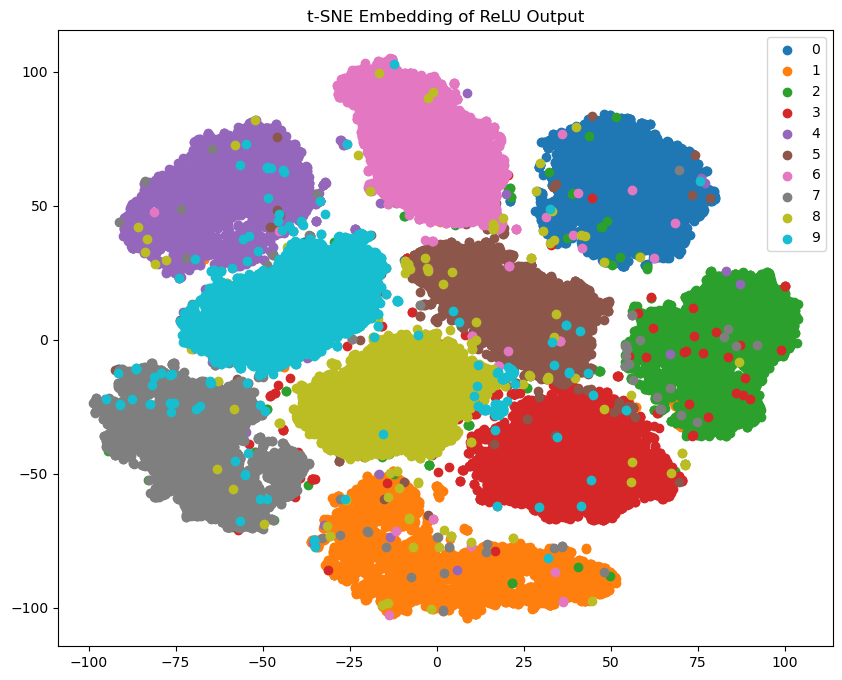

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.030s...
[t-SNE] Computed neighbors for 50000 samples in 40.787s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

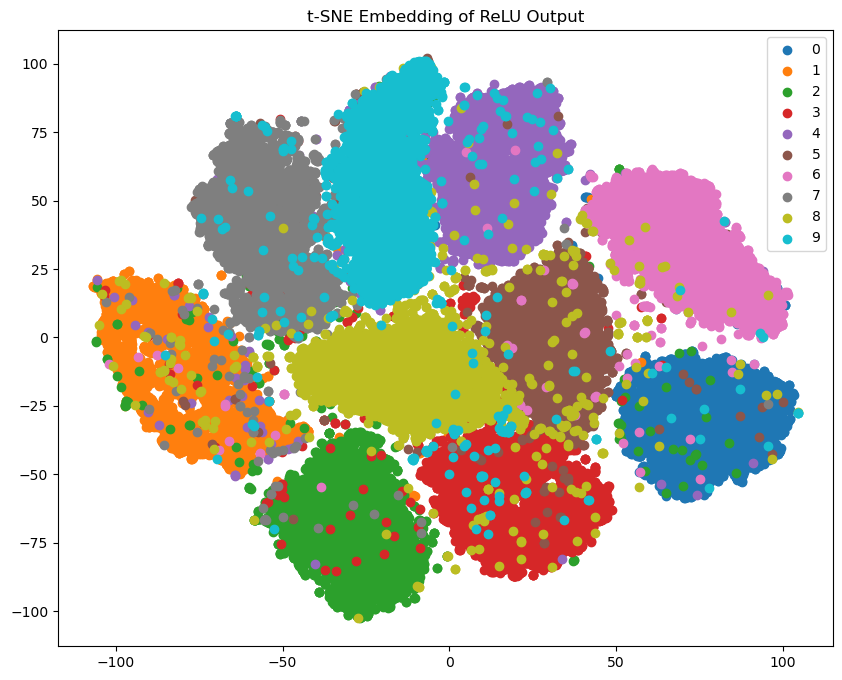

In [86]:
def relu_hook(module, input, output):
    model.relu_output = output

model.relu.register_forward_hook(relu_hook)

train_features, train_labels = get_zi(model, train_dataloader)
tsne_plot(train_features, train_labels)

train_features, train_labels = get_xi(model, train_dataloader)
tsne_plot(train_features, train_labels)
